<a href="https://colab.research.google.com/github/jeff-ai-ml/genai/blob/main/image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
import glob

# --- 1. Install necessary libraries (if not already installed in Colab) ---

In [ ]:
!pip install transformers torch scikit-learn pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# --- 2. Load the pre-trained CLIP model and processor ---

In [ ]:
# Using a smaller, efficient CLIP model for demonstration
model_name = "openai/clip-vit-base-patch32"
processor = AutoProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")

Using device: cuda


# --- 3. Prepare your uploaded images  ---

In [ ]:
image_dir = "/content/uploaded_images"

In [ ]:
# --- Verify the directory and list files ---
if not os.path.exists(image_dir):
    print(f"Error: Directory '{image_dir}' does not exist. Please ensure you've uploaded your images there.")
    # You might want to exit or raise an error here if the directory is essential
    exit()

In [ ]:
# Get a list of image file paths from the directory
# This will find all .jpg, .jpeg, .png, .gif, .bmp files
image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp')
uploaded_image_paths = []
for ext in image_extensions:
    uploaded_image_paths.extend(glob.glob(os.path.join(image_dir, ext)))

uploaded_image_paths.sort() # Sort to ensure consistent order, useful for debugging

if not uploaded_image_paths:
    print(f"No images found in '{image_dir}'. Please ensure your images are in this directory and have common image extensions.")
    exit()

print(f"Found {len(uploaded_image_paths)} uploaded images:")
for path in uploaded_image_paths:
    print(f"- {path}")

Found 10 uploaded images:
- /content/uploaded_images/boat1.jpg
- /content/uploaded_images/butterfly1.jpg
- /content/uploaded_images/flower1.jpg
- /content/uploaded_images/flower2.jpg
- /content/uploaded_images/house1.jpg
- /content/uploaded_images/house2.jpg
- /content/uploaded_images/restraunt1.jpg
- /content/uploaded_images/suv1.jpg
- /content/uploaded_images/trecking.jpg
- /content/uploaded_images/waterfalls1.jpg


# --- 4. Generate embeddings for all uploaded images ---

In [ ]:
def get_image_embedding(image_path, model, processor, device):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy().flatten() # Convert to numpy array and flatten


In [ ]:
print("\nGenerating embeddings for uploaded images...")
uploaded_embeddings = []
for img_path in uploaded_image_paths:
    try:
        embedding = get_image_embedding(img_path, model, processor, device)
        uploaded_embeddings.append(embedding)
    except Exception as e:
        print(f"Could not process image {img_path}: {e}")
        # Optionally, remove this image from uploaded_image_paths if it failed
        # uploaded_image_paths.remove(img_path)


Generating embeddings for uploaded images...


In [ ]:
uploaded_embeddings = np.array(uploaded_embeddings)
print(f"Generated embeddings for {uploaded_embeddings.shape[0]} images, each with dimension {uploaded_embeddings.shape[1]}.")

Generated embeddings for 10 images, each with dimension 512.


# --- 5. Define your query image ---

In [ ]:
query_image_path = "/content/query_images/boats2.jpg"

In [ ]:
# --- Verify query image exists ---
if not os.path.exists(query_image_path):
    print(f"\nError: Query image '{query_image_path}' not found. Please check the path and ensure the image is uploaded.")
    exit()

print(f"\nQuerying with image: {query_image_path}")


Querying with image: /content/query_images/boats2.jpg


# --- 6. Generate embedding for the query image ---

In [ ]:
query_embedding = get_image_embedding(query_image_path, model, processor, device)

# --- 7. Perform similarity search (Cosine Similarity) ---

In [ ]:
# Reshape query_embedding for cosine_similarity function (needs 2D array)
query_embedding_reshaped = query_embedding.reshape(1, -1)

In [ ]:
# Calculate cosine similarity between the query and all uploaded image embeddings
similarities = cosine_similarity(query_embedding_reshaped, uploaded_embeddings)[0]


# --- 8. Rank and display results ---

In [ ]:
# Create a list of (similarity_score, image_path) tuples
results = []
for i, score in enumerate(similarities):
    results.append((score, uploaded_image_paths[i]))

In [ ]:
# Sort by similarity score in descending order
results.sort(key=lambda x: x[0], reverse=True)

In [ ]:
print("\n--- Similarity Search Results (Highest Similarity First) ---")
print(f"Query Image: {query_image_path}\n")


# Determine number of plots for display (query + 10 results)
num_display_images = len(results) + 1
plt.figure(figsize=(num_display_images * 2.5, 6)) # Adjust figure size dynamically




--- Similarity Search Results (Highest Similarity First) ---
Query Image: /content/query_images/boats2.jpg



<Figure size 2750x600 with 0 Axes>

<Figure size 2750x600 with 0 Axes>

(np.float64(-0.5), np.float64(1881.5), np.float64(2837.5), np.float64(-0.5))

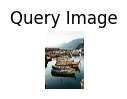

In [ ]:
# Display query image
plt.subplot(1, num_display_images, 1)
plt.imshow(mpimg.imread(query_image_path))
plt.title("Query Image")
plt.axis('off')

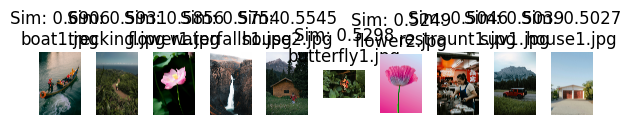

In [ ]:
# Display similar images
for i, (score, path) in enumerate(results):
    # Adjust subplot index based on adding the query image at the start
    plt.subplot(1, num_display_images, i + 2)
    plt.imshow(mpimg.imread(path))
    plt.title(f"Sim: {score:.4f}\n{os.path.basename(path)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Print detailed results
for score, path in results:
    print(f"Image: {os.path.basename(path)}, Similarity: {score:.4f}")

Image: boat1.jpg, Similarity: 0.6906
Image: trecking.jpg, Similarity: 0.5931
Image: flower1.jpg, Similarity: 0.5856
Image: waterfalls1.jpg, Similarity: 0.5754
Image: house2.jpg, Similarity: 0.5545
Image: butterfly1.jpg, Similarity: 0.5298
Image: flower2.jpg, Similarity: 0.5249
Image: restraunt1.jpg, Similarity: 0.5046
Image: suv1.jpg, Similarity: 0.5039
Image: house1.jpg, Similarity: 0.5027
